# Adversarial Robustness Toolbox for Poisoning Attacks on Support Vector Machines (SVM) using Scikitlearn's SVC

In this notebook, we will learn how to use ART to run a poisoning attack on Support Vector Machines. We will be training our data on a subset of the IRIS dataset.

In [1]:
from IPython.display import HTML
HTML('<img src="../data/images/svm_poly.gif">')

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

import os, sys
from os.path import abspath

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from sklearn.svm import SVC, LinearSVC
from sklearn.datasets import load_iris

import numpy as np
from matplotlib import pyplot as plt

from art.classifiers import SklearnClassifier
from art.attacks import PoisoningAttackSVM

np.random.seed(301)

## Utility Functions

In [3]:
def find_duplicates(x_train):
    """
    Returns an array of booleans that is true if that element was previously in the array

    :param x_train: training data
    :type x_train: `np.ndarray`
    :return: duplicates array
    :rtype: `np.ndarray`
    """
    dup = np.zeros(x_train.shape[0])
    for idx, x in enumerate(x_train):
        dup[idx] = np.isin(x_train[:idx], x).all(axis=1).any()
    return dup

In [4]:
def get_data():
    iris = load_iris()
    X = iris.data
    y = iris.target
    
    X = X[y != 0, :2]
    y = y[y != 0]
    labels = np.zeros((y.shape[0], 2))
    labels[y == 2] = np.array([1, 0])
    labels[y == 1] = np.array([0, 1])
    y = labels
    
    n_sample = len(X)
    
    order = np.random.permutation(n_sample)
    X = X[order]
    y = y[order].astype(np.float)
    
    X_train = X[:int(.9 * n_sample)]
    y_train = y[:int(.9 * n_sample)]
    train_dups = find_duplicates(X_train)
    X_train = X_train[train_dups == False]
    y_train = y_train[train_dups == False]
    X_test = X[int(.9 * n_sample):]
    y_test = y[int(.9 * n_sample):]
    test_dups = find_duplicates(X_test)
    X_test = X_test[test_dups == False]
    y_test = y_test[test_dups == False]
    return X_train, y_train, X_test, y_test

In [5]:
def get_adversarial_examples(x_train, y_train, attack_idx, x_val, y_val, kernel):
    # Create ART classfier for scikit-learn SVC
    art_classifier = SklearnClassifier(model=SVC(kernel=kernel), clip_values=(0, 10))
    art_classifier.fit(x_train, y_train)
    init_attack = np.copy(x_train[attack_idx])
    y_attack = np.array([1, 1]) - np.copy(y_train[attack_idx])
    attack = PoisoningAttackSVM(art_classifier, 0.001, 1.0, x_train, y_train, x_val, y_val, max_iters=100)
    final_attack = attack.generate(np.array([init_attack]), y=np.array([y_attack]))
    return final_attack, art_classifier

In [6]:
def plot_results(model, x_train, y_train, x_train_adv, title):
    import matplotlib.pyplot as plt
    import warnings
    warnings.filterwarnings("ignore")

    plt.figure()
    plt.clf()

    get_color = lambda idx: 'orange' if np.argmax(idx) == 1 else 'blue'
    for i_class_2 in [np.array([0, 1]), np.array([1, 0])]:
        mask = np.all(y_train == i_class_2, axis=1)
        plt.scatter(x_train[mask][:, 0], x_train[mask][:, 1], s=20, zorder=2, c=get_color(i_class_2))
    # plt.axes.set_aspect('equal', adjustable='box')

    for sv in model.support_vectors_:
        plt.scatter(sv[0], sv[1], s=200, linewidth=1, facecolors='none', edgecolors='lightgreen',
                             zorder=2)
    h = .01
    x_min, x_max = 1.5, 8.5
    y_min, y_max = 0, 7

    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    Z = model.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.pcolormesh(xx, yy, Z > 0, cmap=plt.cm.Paired)
    plt.contour(xx, yy, Z, colors=['k', 'k', 'k'],
                linestyles=['--', '-', '--'], levels=[-.5, 0, .5])

    x_values = []
    y_values = []
    for adv in x_train_adv:
        x_values.append(adv[0, 0])
        y_values.append(adv[0, 1])
    x_values = np.array(x_values)
    y_values = np.array(y_values)
    plt.scatter(x_values, y_values, zorder=2,
                         c='red', marker='X')
    plt.axes().set_xlim((x_min, x_max))
    plt.axes().set_ylim((y_min, y_max))

    plt.axes().set_title(title)
    plt.axes().set_xlabel('feature 1')
    plt.axes().set_ylabel('feature 2')

## Load Data

In this example, we take two features from the IRIS dataset and train an SVM.

In [7]:
train_data, train_labels, test_data, test_labels = get_data()

## Visualize Effect of Attack on SVM

After training the SVM on just one attack point, a noticable change occurs in the decision boundary for the classifier.

Clean model accuracy on train set (68 samples): 0.7352941176470589
Poison model accuracy on train set (68 samples): 0.7352941176470589
Clean model accuracy on test set (10 samples): 0.6
Poison model accuracy on test set (10 samples): 0.6


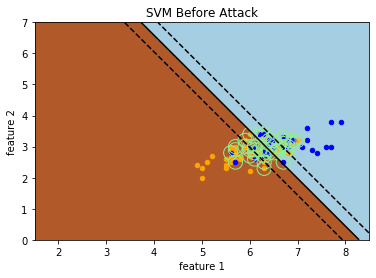

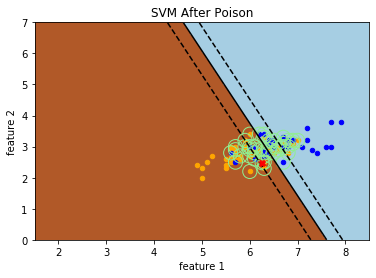

In [8]:
kernel = 'linear' # one of ['linear', 'poly', 'rbf']

attack_point, poisoned = get_adversarial_examples(train_data, train_labels, 0, test_data, test_labels, kernel)
clean = SVC(kernel=kernel)
art_clean = SklearnClassifier(clean, clip_values=(0, 10))
art_clean.fit(x=train_data, y=train_labels)

plot_results(art_clean._model, train_data, train_labels, [], "SVM Before Attack")
plot_results(poisoned._model, train_data, train_labels, [attack_point], "SVM After Poison")

clean_acc_train = np.average(np.all(art_clean.predict(train_data) == train_labels, axis=1))
poison_acc_train = np.average(np.all(poisoned.predict(train_data) == train_labels, axis=1))
clean_acc_test = np.average(np.all(art_clean.predict(test_data) == test_labels, axis=1))
poison_acc_test = np.average(np.all(poisoned.predict(test_data) == test_labels, axis=1))

print("Clean model accuracy on train set ({} samples): {}".format(len(train_labels), clean_acc_train))
print("Poison model accuracy on train set ({} samples): {}".format(len(train_labels), poison_acc_train))
print("Clean model accuracy on test set ({} samples): {}".format(len(test_labels), clean_acc_test))
print("Poison model accuracy on test set ({} samples): {}".format(len(test_labels), poison_acc_test))

A perfect classifier would have all points in yellow on the orange side of the decision boundary and all points in blue on the light blue side of the decision boundary. The attack point is shown in red and support vectors are circled.

Even with small changes in overall accuracy, inserting just a *single* poison point can have major impacts on the model's ability to generalize well. 